<a href="https://colab.research.google.com/github/CarsonHhs/InventoryManagement/blob/main/OilPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

In [152]:
#output = activation(dot(input, kernel) + bias)

def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

In [153]:
df = pd.read_csv('/content/drive/MyDrive/Colab/Price.csv')

In [154]:
df['Date'] = pd.to_datetime(df['Date'])
#df = df.reindex(index= df.index[::-1])

In [155]:
zaman = np.arange(1, len(df) + 1, 1)
OHCL_avg = df.mean(axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


In [156]:
OHCL_avg = np.reshape(OHCL_avg.values, (len(OHCL_avg),1)) 
scaler = MinMaxScaler(feature_range=(0,1))
OHCL_avg = scaler.fit_transform(OHCL_avg)

In [157]:
#print(OHCL_avg)
train_OHLC = int(len(OHCL_avg)*0.9)
test_OHLC = len(OHCL_avg) - train_OHLC

train_OHLC, test_OHLC = OHCL_avg[0:train_OHLC,:], OHCL_avg[train_OHLC:len(OHCL_avg),:]

In [158]:
#Train the datasets and test it
trainX, trainY = new_dataset(train_OHLC,1)
testX, testY = new_dataset(test_OHLC,1)

In [159]:
trainX = np.reshape(trainX, (trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0],1,testX.shape[1]))
step_size = 1

In [160]:
model = Sequential()
model.add(LSTM(128, input_shape=(1, step_size)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.add(Activation('linear'))

In [161]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=25, verbose=2)

Epoch 1/10
16/16 - 3s - loss: 0.1057
Epoch 2/10
16/16 - 0s - loss: 0.0630
Epoch 3/10
16/16 - 0s - loss: 0.0407
Epoch 4/10
16/16 - 0s - loss: 0.0315
Epoch 5/10
16/16 - 0s - loss: 0.0266
Epoch 6/10
16/16 - 0s - loss: 0.0220
Epoch 7/10
16/16 - 0s - loss: 0.0168
Epoch 8/10
16/16 - 0s - loss: 0.0128
Epoch 9/10
16/16 - 0s - loss: 0.0089
Epoch 10/10
16/16 - 0s - loss: 0.0061


In [162]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)

testY = scaler.inverse_transform([testY])

In [163]:
trainScore = math.sqrt(mean_squared_error(trainY[0], 
                       trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], 
                       testPredict[:,0]))

In [164]:
trainPredictPlot = np.empty_like(OHCL_avg)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size,:] = trainPredict

In [165]:
testPredictPlot = np.empty_like(OHCL_avg)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHCL_avg)-1,:] = testPredict

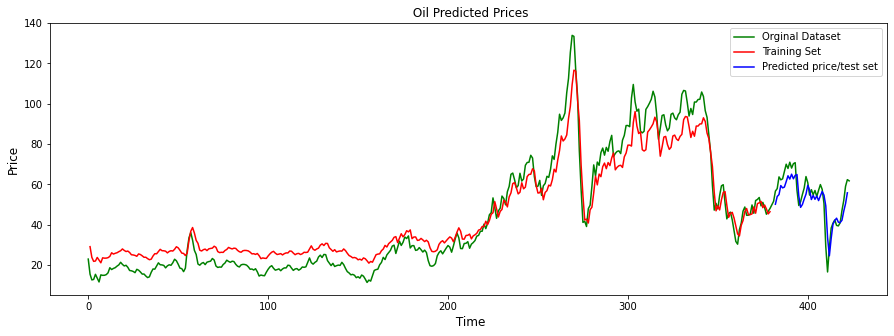

In [166]:
plt.figure(figsize=(15, 5))

OHCL_avg = scaler.inverse_transform(OHCL_avg)

plt.plot(OHCL_avg, 'g', label='Orginal Dataset')
plt.plot(trainPredictPlot, 'r', label='Training Set')
plt.plot(testPredictPlot, 'b', label='Predicted price/test set')
plt.title(" Oil Predicted Prices")
plt.xlabel(' Time', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='upper right')
plt.show()